$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="white", color_codes=True)
np.random.seed(0)

In [2]:
def scatter_plot_with_marginals(A):
    g = sns.JointGrid(x=A[:, 0], y=A[:, 1])
    g = g.plot_joint(plt.scatter, color="orange")
    g.ax_marg_x.hist(A[:, 0], color="b", alpha=1) 
    g.ax_marg_y.hist(A[:, 1], color="r", alpha=1, orientation="horizontal")
    plt.show()

Create source data for demo.

In [3]:
s1 = 2 * np.sin(np.linspace(0, 12 * 2 * np.pi, 200))
s2 = np.random.laplace(0, 0.5, 200)
z = np.array([s1, s2]).T
z -= np.mean(z, axis=0)

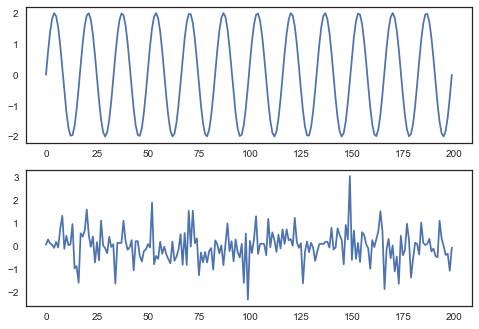

In [4]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(z[:, 0])
ax2.plot(z[:, 1])
plt.show()

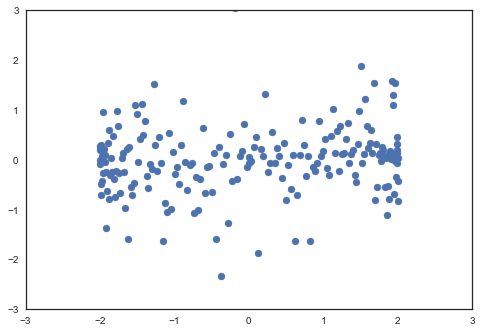

In [5]:
plt.scatter(s1, s2)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

Mix the sources.

In [6]:
def rotate(matrix, degrees):
    R = np.array([[np.cos(degrees), -np.sin(degrees)],
                  [np.sin(degrees), np.cos(degrees)]])
    return matrix @ R

def scale(matrix, scaling_factors):
    return matrix @ np.diag(scaling_factors)

In [7]:
S = np.diag(np.array([0.5, 2.0]))
degrees = 45
R = np.array([[np.cos(degrees), -np.sin(degrees)],
              [np.sin(degrees), np.cos(degrees)]])
T = S @ R

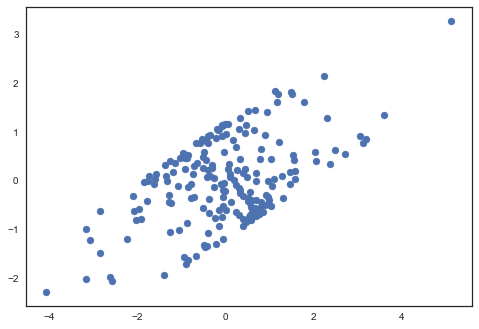

In [8]:
x = z @ T
x -= np.mean(x, axis=0)

plt.scatter(x[:, 0], x[:, 1])
plt.show()

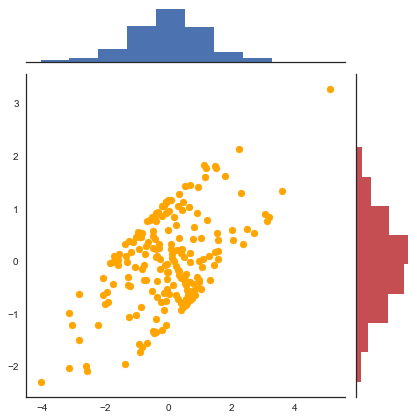

In [9]:
scatter_plot_with_marginals(x)

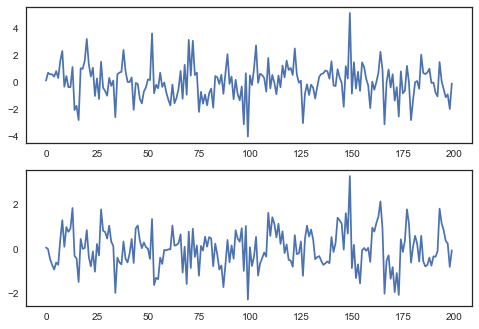

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(x[:, 0])
ax2.plot(x[:, 1])
plt.show()

Now whiten the data.

In [11]:
def covariance_matrix(A):
    assert len(A.shape) == 2
    N, _ = A.shape
    mu = np.mean(A, axis=0)
    return (A - mu).T @ (A - mu) / (N - 1)

In [12]:
L, Q = np.linalg.eigh(covariance_matrix(x))
y = x @ Q @ np.diag(1 / np.sqrt(L))

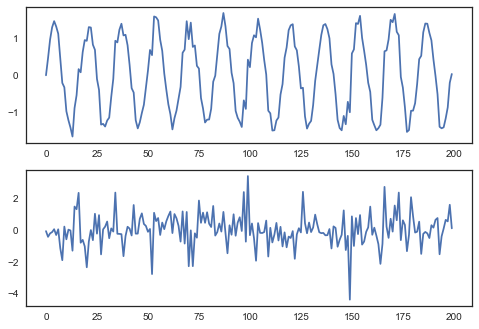

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(y[:, 0])
ax2.plot(y[:, 1])
plt.show()

We now implement FastICA. We collect all weight vectors $\bw_i$ as rows in a weight matrix $W$. We then iterate the following two steps until convergence:

1. For each $\bw_i$, update as $\bw_i \leftarrow \E[\bx g(\bw_i^T \bx)] - \E[g'(\bw_i^T\bx)]\bw_i$, where expectations are sample averages
2. Symmetrically decorrelate W as $W \leftarrow (WW^T)^{-1}W$

with $g = \tanh, g' = 1 - \tanh^2$.

In [14]:
def g(X):
    th = np.tanh(X, X)
    return th, np.mean(1 - th ** 2, axis=0)

In [15]:
def fast_ICA_iteration(X, W, g):
    g_wtx, g_prime_wtx = g(X @ W.T)
    return g_wtx.T @ X / X.shape[0] - g_prime_wtx[:, None] * W

In [16]:
def symmetric_decorrelation(W):
    L, Q = np.linalg.eigh(W @ W.T)
    return Q @ np.diag(1 / np.sqrt(L)) @ Q.T @ W

In [17]:
def fast_ICA(X, g, max_iters=100, tol=1e-4):
    _, D = X.shape
    
    W = np.random.normal(size=(D, D))
    W = symmetric_decorrelation(W)
    
    for _ in range(max_iters):
        W_ = fast_ICA_iteration(X, W, g)
        W_ = symmetric_decorrelation(W_)
        delta = np.max(np.abs(np.abs(np.diag(W @ W_.T)) - 1))
        W = W_
        if delta < tol:
            break

    return W

Reconstructed signals.

In [19]:
W = fast_ICA(y, g)
reconstructed_s = y @ W.T

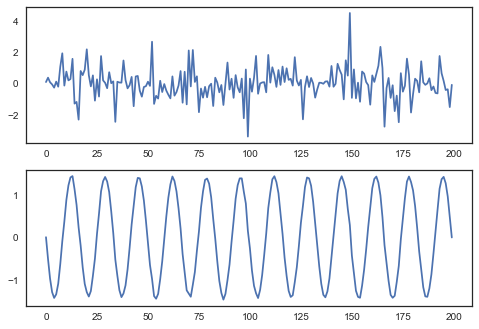

In [20]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(reconstructed_s[:, 0])
ax2.plot(reconstructed_s[:, 1])
plt.show()